## Simulation Framework 

In [1]:
import import_ipynb
import math 
import importlib
import random
import copy
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# import functions from model_evaluation.ipynb  
import model_evaluation 

importing Jupyter notebook from model_evaluation.ipynb


In [12]:
# simulation parameters 

# number of groups
n_groups = 10 

# number of agents 
n_agents = 10

# Iterations for group distributions 
iterations = 1000

# Number of vote distributions 
sim = 100

### Group Distributions 

In [3]:
# create random distributions 
def distribute_agents(n_agents, n_groups):
    """
    This function randomly selects a subset of group indices for each agent. The number of groups for each agent is randomly chosen between 1 and the total number of groups.
    :returns (list of lists): Each inner list represents the agents assigned to a particular group.
    """
    group_dist = [[] for _ in range(n_groups)]

    for agent in range(n_agents):
        groups = random.sample(range(n_groups), random.randint(1, n_groups))
        for group in groups:
            group_dist[group].append(agent)

    return group_dist

In [4]:
# Create random group distributions with a gradual transition from one to the other extreme 
def gradual_distribution_transition(n_agents, n_groups, iterations):
    """
    This function starts with a distribution where each group contains only one agent and gradually modifies it in each iteration.
    :returns (list of lists): Each inner list represents the agents assigned to a particular group.
    """
    # Initial distribution: Each group contains only one agent
    group_dist = [[agent] for agent in range(n_agents)]

    # List to store distributions at each iteration
    distributions = [copy.deepcopy(group_dist)]

    for _ in range(iterations):  # Start from iteration 1
        # Randomly select a group
        source_group = random.randint(0, n_groups - 1)
        
        # Randomly select a destination group different from the source group
        possible_destination_groups = [group for group in range(n_groups) if group != source_group]
        destination_group = random.choice(possible_destination_groups)

        # Randomly select an agent from the source group
        if group_dist[source_group]:
            agent_to_move = random.choice(group_dist[source_group])

            # Move the agent to the destination group if not already present
            if agent_to_move not in group_dist[destination_group]:
                group_dist[destination_group].append(agent_to_move)
            else:
                continue

        # Save the current distribution (deep copy to avoid referencing the same object)
        distributions.append(copy.deepcopy(group_dist))

    return distributions

In [15]:
result_group_distributions = gradual_distribution_transition(n_agents=n_agents, n_groups=n_groups, iterations=iterations)
# print(result_group_distributions[-1])
# print(len(result_group_distributions))

In [6]:
# Custom Group Distributions 

# result_group_distributions = [[[0], [1]], [[0, 1], [1]], [[0, 1], [1, 0]]]
# result_group_distributions = [[[0], [1]], [[0, 1], [1, 0]]]
# result_group_distributions = [[[0, 1], [1]], [[0, 1], [1, 0]]]
# print(result_group_distributions)

### Vote Distribution 

In [7]:
# define fixed vote distribution 
def vote_distribution_fixed(n_agents, votes_agent):
    return [votes_agent] * n_agents

In [ ]:
vote_dist = vote_distribution_fixed(n_agents=n_agents, votes_agent=5)
# print(vote_dist)

In [9]:
def vote_distribution_random(n_agents, sim):
    list_vote_dist = []
    for _ in range(sim):
        vote_dist = [random.randint(1, 100) for _ in range(n_agents)]
        list_vote_dist.append(vote_dist)
    return list_vote_dist 

In [16]:
list_vote_dist = vote_distribution_random(n_agents=n_agents, sim=sim)
# print(list_vote_dist)

### Group Membership

In [9]:
list_result_group_memberships = []
for i in range(len(result_group_distributions)): 
    result_group_memberships = model_evaluation.group_memberships(groups=result_group_distributions[i], votes=vote_dist)
    list_result_group_memberships.append(result_group_memberships)

# print(list_result_group_memberships[-1])

In [10]:
# result_commom_group = model_evaluation.common_group(1,0, memberships_group=list_result_group_memberships[1])
# print(result_commom_group)

In [11]:
# result_K = model_evaluation.K(agent_i=0, group=result_group_distributions[1][1], votes=vote_dist, memberships_group=list_result_group_memberships[1])
# print(result_K)

### Model Terms 

In [18]:
# first term 
dict_result_group_first_term = {}
list_result_aggregated_weight_term_1 = []
for i in range(len(result_group_distributions)):  # len(result_group_distributions) == len(list_result_group_memberships)
    result_groups, result_aggregate_weight = model_evaluation.first_term(groups=result_group_distributions[i], votes=vote_dist, memberships_group=list_result_group_memberships[i])
    dict_result_group_first_term[i] = {'individual_contributions': result_groups}
    list_result_aggregated_weight_term_1.append(result_aggregate_weight)

# print(list_result_aggregated_weight_term_1)
# print(dict_result_group_first_term)

In [13]:
# interaction terms
dict_result_individual_interaction_terms = {}
list_result_aggregated_weight_interaction_terms = []
for i in range(len(result_group_distributions)):  # len(result_group_distributions) == len(list_result_group_memberships)
    result_individual, result_aggregated = model_evaluation.interaction_terms(groups=result_group_distributions[i], memberships_group=list_result_group_memberships[i], votes=vote_dist)
    dict_result_individual_interaction_terms[i] = {'individual_contributions': result_individual}
    list_result_aggregated_weight_interaction_terms.append(result_aggregated)

# print(dict_result_individual_interaction_terms)
# print(list_result_aggregated_weight_interaction_terms)   


### Plurality and QV Scorese 

In [14]:
list_plurality_scores = []
for i in range(len(list_result_aggregated_weight_term_1)):   
    plurality_score = model_evaluation.connection_oriented_cluster_match(term_1=list_result_aggregated_weight_term_1[i], interaction_terms=list_result_aggregated_weight_interaction_terms[i])
    list_plurality_scores.append(plurality_score)

# print(list_plurality_scores)

In [15]:
result_quadratic_voting, result_sum_quadratic_votes = model_evaluation.quadratic_voting(votes=vote_dist)
# print(result_quadratic_voting)
# print(result_sum_quadratic_votes)

### Jaccard Index 

In [16]:
global_jaccard_index = []
for i in range(len(result_group_distributions)):
    pairwise_jaccard_matrix = model_evaluation.pairwise_jaccard_similarity(groups=result_group_distributions[i])
    # print("Pairwise Jaccard Similarity Matrix:")
    # for row in pairwise_jaccard_matrix:
    #    print(row)

    global_similarity = model_evaluation.global_jaccard_similarity(pairwise_jaccard_matrix)
    global_jaccard_index.append(global_similarity)

# print(global_jaccard_index)


### Plot


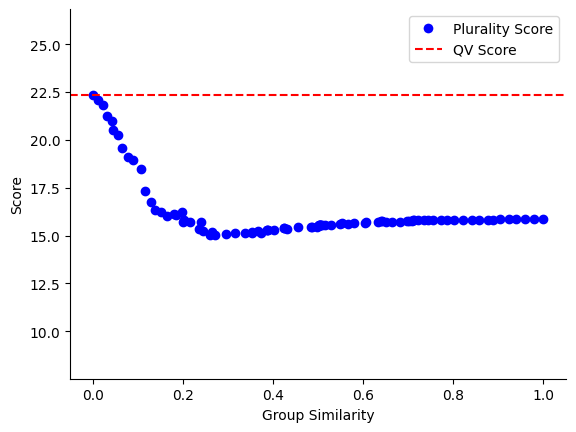

In [17]:
x_values = global_jaccard_index
y_values = list_plurality_scores
qv_score = result_sum_quadratic_votes

# Create scatter plot
scatter = plt.scatter(x_values, y_values, color='b', label='Plurality Score')

# Add labels
plt.xlabel('Group Similarity')
plt.ylabel('Score')

# Remove plot title
plt.title('')  # Empty string to remove the title

# Remove the right and upper borders of the box
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Add a horizontal line for the QV score
plt.axhline(y=qv_score, color='r', linestyle='--', label='QV Score')

# Set y-axis limits from 0 to 120% of the QV score
plt.ylim(0.5*min(y_values), 1.2 * qv_score)

# Add Plurality Score to legend
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=8, label='Plurality Score'),
                   Line2D([0], [0], color='r', linestyle='--', label='QV Score')]
plt.legend(handles=legend_elements)

# Show the plot
plt.show()
